# Using Groq’s Llama Model with LlamaIndex Agents

This notebook demonstrates how to use LlamaIndex’s ReActAgent with Groq's Llama model to perform arithmetic operations.
We define function tools for multiplication and addition, integrate them into an agent, and execute agent workflows.

### Requirements
Ensure that you have the necessary dependencies installed:
- `llama-index`
- `groq`

We will use function tools to process mathematical queries and explore how the agent interacts with these tools.


In [ ]:
!pip install llama-index groq llama-index-llms-groq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.2 MB/s eta 0:00:00


## Import Required Modules

We import the necessary components from `llama_index` to set up the function tools, agents, and workflows.


In [ ]:
from llama_index.core.agent.workflow import FunctionAgent, ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.core.agent.workflow import AgentWorkflow

from llama_index.llms.groq import Groq
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API')


## Define Function Tools

We define two simple mathematical functions:
1. `multiply(a, b)`: Multiplies two integers.
2. `add(a, b)`: Adds two integers.

These functions will be converted into `FunctionTool` objects, allowing the agent to call them as needed.


In [ ]:
def multiply(a: int, b: int) -> int:
    return a * b

def add(a: int, b: int) -> int:
    return a + b

multiply_tool = FunctionTool.from_defaults(fn=multiply, name="multiply", description="Multiplies two integers")
add_tool = FunctionTool.from_defaults(fn=add, name="add", description="Adds two integers")


## Initialize Groq’s Llama Model

We use the `Groq` class to initialize the Llama-3.3-70B model. This model will be used by the agent to process queries.


In [ ]:
llm = Groq(model="llama-3.3-70b-specdec", api_key=GROQ_API_KEY)


## Define the ReActAgent

The `ReActAgent` is designed to handle arithmetic operations using our defined function tools. It receives a system prompt and interacts with the Llama model.


In [ ]:
math_agent = ReActAgent(
    name="MathAgent",
    description="Useful for arithmetic operations",
    system_prompt="You are the Math expert",
    llm=llm,
    tools=[multiply_tool, add_tool]
)


## Set Up the Agent Workflow

The `AgentWorkflow` class allows us to define a sequence of agents that interact to solve a problem. Here, we set up a simple workflow with our `math_agent`.


In [ ]:
agent_workflow = AgentWorkflow(agents=[math_agent], root_agent=math_agent)


## Running the Agent Workflow

We run the agent workflow by passing a user query that asks for a mathematical computation.


In [ ]:
result = await agent_workflow.run(user_msg="What is 5 plus 10, then multiply the result by 2?")
result


AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='30')]), tool_calls=[], raw={'id': 'chatcmpl-0bf39e6f-d81c-4598-aafb-98bde55408a5', 'choices': [{'delta': {'content': None, 'function_call': None, 'refusal': None, 'role': None, 'tool_calls': None}, 'finish_reason': 'stop', 'index': 0, 'logprobs': None}], 'created': 1738391395, 'model': 'llama-3.3-70b-specdec', 'object': 'chat.completion.chunk', 'service_tier': None, 'system_fingerprint': 'fp_74379b522c', 'usage': None, 'x_groq': {'id': 'req_01jk037750fe6bwxzv90fprapa', 'usage': {'queue_time': 0.05418596199999999, 'prompt_tokens': 759, 'prompt_time': 0.094097216, 'completion_tokens': 35, 'completion_time': 0.016896891, 'total_tokens': 794, 'total_time': 0.110994107}}}, current_agent_name='MathAgent')

In [ ]:
result.response.blocks[0].text

'30'

## Streaming Agent Events

We can monitor the agent’s actions by streaming events, which include tool calls and responses.


In [ ]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = agent_workflow.run(user_msg="What is 5 plus 10, then multiply the result by 2?")

current_agent = None
current_tool_calls = ""
async for event in handler.stream_events():
    if (
        hasattr(event, "current_agent_name")
        and event.current_agent_name != current_agent
    ):
        current_agent = event.current_agent_name
        print(f"\n{'='*50}")
        print(f"🤖 Agent: {current_agent}")
        print(f"{'='*50}\n")
    elif isinstance(event, AgentOutput):
        if event.response.content:
            print("📤 Output:", event.response.content)
        if event.tool_calls:
            print(
                "🛠️  Planning to use tools:",
                [call.tool_name for call in event.tool_calls],
            )
    elif isinstance(event, ToolCallResult):
        print(f"🔧 Tool Result ({event.tool_name}):")
        print(f"  Arguments: {event.tool_kwargs}")
        print(f"  Output: {event.tool_output}")
    elif isinstance(event, ToolCall):
        print(f"🔨 Calling Tool: {event.tool_name}")
        print(f"  With arguments: {event.tool_kwargs}")



🤖 Agent: MathAgent

📤 Output: Thought: The current language of the user is: English. I need to use a tool to help me answer the question. First, I need to add 5 and 10, then multiply the result by 2. I will start by adding 5 and 10.
Action: add
Action Input: {"a": 5, "b": 10}
🛠️  Planning to use tools: ['add']
🔨 Calling Tool: add
  With arguments: {'a': 5, 'b': 10}
🔧 Tool Result (add):
  Arguments: {'a': 5, 'b': 10}
  Output: 15
📤 Output: Thought: I have the result of the addition, which is 15. Now, I need to multiply this result by 2 to get the final answer.
Action: multiply
Action Input: {"a": 15, "b": 2}
🛠️  Planning to use tools: ['multiply']
🔨 Calling Tool: multiply
  With arguments: {'a': 15, 'b': 2}
🔧 Tool Result (multiply):
  Arguments: {'a': 15, 'b': 2}
  Output: 30
📤 Output: Thought: I can answer without using any more tools. I'll use the user's language to answer. The result of the operations is 30.
Answer: 30


In [ ]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = agent_workflow.run(user_msg="What is 5 and 10, then its product by 2?")

current_agent = None
current_tool_calls = ""
async for event in handler.stream_events():
    if (
        hasattr(event, "current_agent_name")
        and event.current_agent_name != current_agent
    ):
        current_agent = event.current_agent_name
        print(f"\n{'='*50}")
        print(f"🤖 Agent: {current_agent}")
        print(f"{'='*50}\n")
    elif isinstance(event, AgentOutput):
        if event.response.content:
            print("📤 Output:", event.response.content)
        if event.tool_calls:
            print(
                "🛠️  Planning to use tools:",
                [call.tool_name for call in event.tool_calls],
            )
    elif isinstance(event, ToolCallResult):
        print(f"🔧 Tool Result ({event.tool_name}):")
        print(f"  Arguments: {event.tool_kwargs}")
        print(f"  Output: {event.tool_output}")
    elif isinstance(event, ToolCall):
        print(f"🔨 Calling Tool: {event.tool_name}")
        print(f"  With arguments: {event.tool_kwargs}")



🤖 Agent: MathAgent

📤 Output: Thought: The current language of the user is: English. I need to use a tool to help me answer the question. First, I need to add 5 and 10.
Action: add
Action Input: {"a": 5, "b": 10}
🛠️  Planning to use tools: ['add']
🔨 Calling Tool: add
  With arguments: {'a': 5, 'b': 10}
🔧 Tool Result (add):
  Arguments: {'a': 5, 'b': 10}
  Output: 15
📤 Output: Thought: Now that I have the sum of 5 and 10, which is 15, I need to find the product of 15 and 2.
Action: multiply
Action Input: {"a": 15, "b": 2}
🛠️  Planning to use tools: ['multiply']
🔨 Calling Tool: multiply
  With arguments: {'a': 15, 'b': 2}
🔧 Tool Result (multiply):
  Arguments: {'a': 15, 'b': 2}
  Output: 30
📤 Output: Thought: I can answer without using any more tools. I'll use the user's language to answer. The sum of 5 and 10 is 15, and the product of 15 and 2 is 30.
Answer: The result of the given operations is 30.


In [17]:
## Create Recommendation Agent

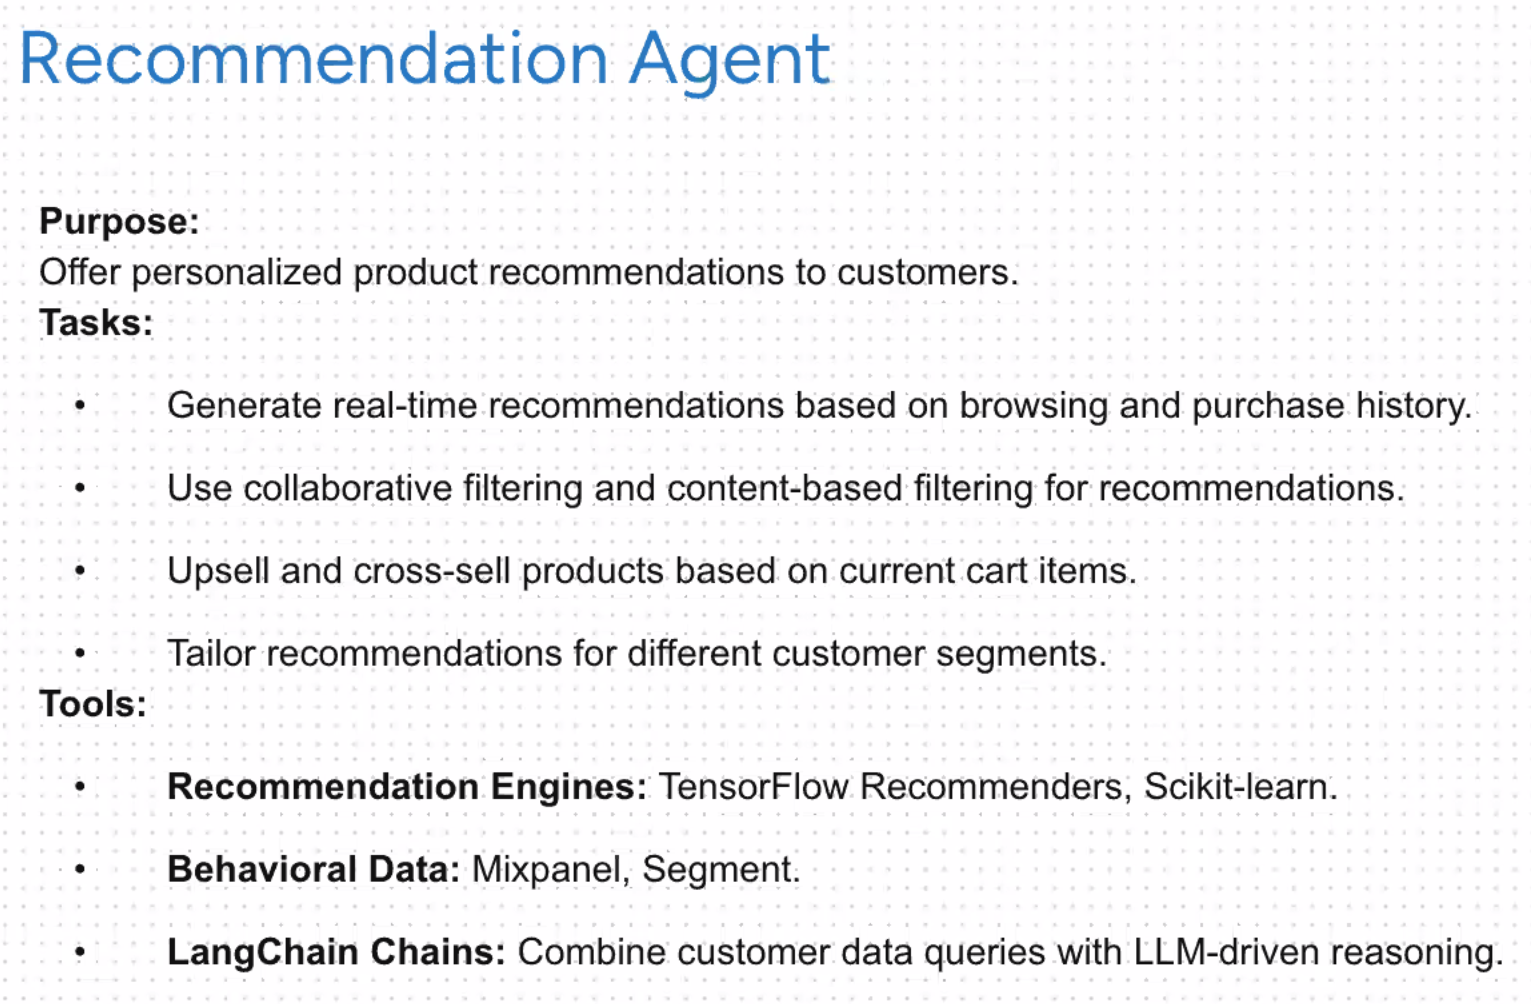